# Bone Segmentation with Datamint and Pytorch Lightning

In this notebook, we will use [Datamint](https://sonanceai.github.io/datamint-python-api/) + [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) to run a segmentation task on a 2D dataset of bone images.

## Creating experiments and loading datasets

Let's first create a new experiment for project "BoneSeg":

In [1]:
from datamintapi import Experiment

exp = Experiment(
    name="Experiment1",
    project_name="BoneSeg",
    allow_existing=True,
    auto_log=False,
)

With the experiment created, we can load the train dataset and the test through the Experiment class using `exp.get_dataset(...)` method.
So, let's load the train dataset and the test while specifying proper transformations:

> [!TIP]
> Check more handy transformations [parameters for DatamintDataset class in documentation](https://sonanceai.github.io/datamint-python-api/datamint.dataset.html#datamintapi.dataset.dataset.DatamintDataset)

In [2]:
from torchvision.transforms import v2
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

IMAGE_SIZE = (520, 520)

image_transform = v2.Compose([v2.Resize(IMAGE_SIZE),
                              v2.Grayscale(num_output_channels=3),
                              v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.0, hue=0.0),
                              DeepLabV3_ResNet50_Weights.DEFAULT.transforms(),
                              ])

# It is important to use NEAREST interpolation for masks.
mask_transform = v2.Resize(IMAGE_SIZE, antialias=False, interpolation=v2.InterpolationMode.NEAREST)


dataset_params = dict(
    return_as_semantic_segmentation=True,  # Transforms instance segmentation into semantic segmentation.
    semantic_seg_merge_strategy="union",  # Merges all author's masks into a single one.
    return_frame_by_frame=True,  # Iterates over each frame of the video, instead of the video as a whole.
    image_transform=image_transform,  # Transforms the image.
    mask_transform=mask_transform,  # Transforms the mask.
    discard_without_annotations=True,  # Discards images without annotations.
)

Dtrain = exp.get_dataset(
    **dataset_params,
    split='train'
)

Dtest = exp.get_dataset(
    **dataset_params,
    split='test'
)
print(len(Dtrain), len(Dtest))

24 3


Let's plot a single image from the training dataset:

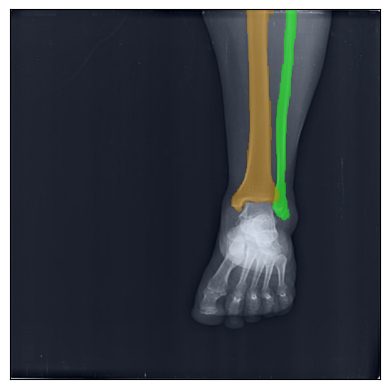

In [3]:
from datamintapi.utils.visualization import draw_masks, show

item = Dtrain[-1]

segs = item['segmentations']  # Tensor of shape (L, H, W), where L is the number of labels plus background.
# segs[0] is the background mask

image = item['image']  # Tensor of shape (C, H, W)
segs_names = Dtrain.segmentation_labels_set  # (list of str)

# draw the segmentations
image_with_mask = draw_masks(image,
                             masks=segs[1:] == 1)
show(image_with_mask)

Let's create the dataloaders by using the `.get_dataloader(...)` method. 

In [4]:
train_dataloader = Dtrain.get_dataloader(batch_size=8, num_workers=4, shuffle=True)
test_dataloader = Dtest.get_dataloader(batch_size=2, num_workers=4, shuffle=False)
# Check the dataloader
sample_batch = next(iter(train_dataloader))
print(sample_batch['image'].shape)  # (8, 3, 520, 520)
print(sample_batch['segmentations'].shape) # (8, 5, 520, 520)

torch.Size([8, 3, 520, 520])
torch.Size([8, 5, 520, 520])


## Defining our model

We will use the DeepLabV3 model from `segmentation_models_pytorch` library, metrics from `torchmetrics` and `datamintapi.utils.torchmetrics import SegmentationToClassificationWrapper` to wrap the Classification metrics in order to work with the segmentation task.

In [8]:
import lightning as L
import torchvision
from torch import nn
from torchvision.models.segmentation import deeplabv3_resnet50
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Recall, Precision, F1Score, Specificity, Accuracy
from datamintapi.utils.torchmetrics import SegmentationToClassificationWrapper
from torch import Tensor
import torch


class MyModel(L.LightningModule):
    def __init__(self,
                 num_classes: int,
                 experiment: Experiment = None):
        super().__init__()
        # self.model = MyModel.initialize_model_mobilenet(num_classes+1,
        #                                                 weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
        self.experiment = experiment
        self.model = MyModel.initialize_model(num_classes+1)
        self.criterion = nn.CrossEntropyLoss()
        self.num_classes = num_classes

        # train metrics #
        self.train_cls_metrics = self.create_cls_metrics()
        self.train_seg_metrics = self.create_seg_metrics()

        # val metrics #
        self.val_cls_metrics = self.create_cls_metrics()
        self.val_seg_metrics = self.create_seg_metrics()

        # test metrics #
        self.test_cls_metrics = self.create_cls_metrics()
        self.test_seg_metrics = self.create_seg_metrics()

    def create_seg_metrics(self) -> nn.ModuleDict:
        """
        Create the segmentation metrics.
        """
        metrics = nn.ModuleDict()
        metrics["iou"] = MeanIoU(num_classes=self.num_classes+1, include_background=True)
        return metrics

    def create_cls_metrics(self) -> nn.ModuleDict:
        """
        Create the classification metrics. It uses the SegmentationToClassificationWrapper
        to convert the segmentation masks into classification masks.
        """
        metrics = nn.ModuleDict()
        for clsmetric_cls in [Recall, Precision, F1Score, Specificity, Accuracy]:
            clsmetric_obj = clsmetric_cls(task="multilabel", num_labels=self.num_classes+1, average="macro")
            metric = SegmentationToClassificationWrapper(clsmetric_obj, iou_threshold=0.5)
            metrics[clsmetric_cls.__name__] = metric

        return metrics

    def initialize_model(num_classes: int, weights='DEFAULT'):
        """
        Initialize the backbone model with the given number of classes.
        """
        model = deeplabv3_resnet50(weights=weights)
        model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, num_classes)
        return model

    def forward(self, x) -> Tensor:
        return self.model(x)['out']

    def predict_step(self, batch: dict, batch_idx, dataloader_idx=0):
        x = batch["image"]
        y_hat = self(x)
        return y_hat > 0

    def _get_metrics(self, phase: str) -> tuple:
        if phase == 'train':
            seg_metrics = self.train_seg_metrics
            cls_metrics = self.train_cls_metrics
        elif phase == 'val':
            seg_metrics = self.val_seg_metrics
            cls_metrics = self.val_cls_metrics
        elif phase == 'test':
            seg_metrics = self.test_seg_metrics
            cls_metrics = self.test_cls_metrics
        else:
            raise ValueError(f"Invalid phase: {phase}")
        return seg_metrics, cls_metrics

    def _run_step(self, batch: dict, batch_idx, phase: str) -> Tensor:
        x = batch["image"]
        y = batch["segmentations"]
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_hat = y_hat > 0
        if phase is not None:
            y = y.to(torch.bool)
            seg_metrics, cls_metrics = self._get_metrics(phase)

            for metric in seg_metrics.values():
                metric.update(y_hat, y)
            for metric in cls_metrics.values():
                metric.update(y_hat, y)

            self.log(f"{phase}/loss", loss, prog_bar=True, on_epoch=True, on_step=False, batch_size=len(x))

        return loss

    def training_step(self,
                      batch: dict,
                      batch_idx):
        loss = self._run_step(batch, batch_idx, phase='train')
        return loss

    def log(self, name, value, *args, log_to_datamint=False, **kwargs):
        """Log a metric value.
        This method is a wrapper around the PyTorch Lightning `log` method
        so that we can also log to Datamint via the experiment object.
        """
        super().log(name, value, *args, **kwargs)
        if self.experiment is not None and log_to_datamint:
            try:
                if isinstance(value, torch.Tensor):
                    value = value.item()
                self.experiment.log_metric(name, value,
                                           #    show_in_summary=name.startswith('test')
                                           )
            except Exception as e:
                print(f"ERROR: Failed to log metric {name}: {e}")

    def validation_step(self, batch: dict, batch_idx):
        self._run_step(batch, batch_idx, phase='val')

    def test_step(self, batch: dict, batch_idx):
        self._run_step(batch, batch_idx, phase='test')

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-4, weight_decay=1e-3)

    def _compute_metrics_end(self, phase: str):
        seg_metrics, cls_metrics = self._get_metrics(phase)
        for name, metric in seg_metrics.items():
            self.log(f"{phase}/{name}", metric.compute(), on_epoch=True, on_step=False, log_to_datamint=True)
            metric.reset()
        for name, metric in cls_metrics.items():
            self.log(f"{phase}/{name}", metric.compute(), on_epoch=True, on_step=False, log_to_datamint=True)
            metric.reset()

    def on_train_epoch_end(self):
        self._compute_metrics_end('train')

    def on_validation_epoch_end(self):
        self._compute_metrics_end('val')

    def on_test_epoch_end(self):
        self._compute_metrics_end('test')


In [9]:
model = MyModel(num_classes=len(Dtrain.segmentation_labels_set),
                experiment=exp)

# Training

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val/loss',          # Monitor validation loss
    filename='boneseg-{epoch:02d}-{val/loss:.4f}',
    save_top_k=1,                # Save only the best model
    mode='min',                  # Lower val loss is better
    save_last=False,              # Also save the last model
    verbose=False,
    auto_insert_metric_name=False,
)

save_last_epoch = ModelCheckpoint()

trainer = L.Trainer(
    accelerator='gpu',
    max_epochs=60,
    callbacks=[checkpoint_callback, save_last_epoch],
)

trainer.fit(model,
            train_dataloaders=train_dataloader,
            # Ideally, we should use be a separated validation set, but for simplicity we use the test set:
            val_dataloaders=test_dataloader
            )

In [11]:
# test
trainer.test(model, dataloaders=test_dataloader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.7333333492279053     │
│       test/F1Score        │    0.6599999666213989     │
│      test/Precision       │     0.800000011920929     │
│        test/Recall        │    0.6000000238418579     │
│     test/Specificity      │    0.4000000059604645     │
│         test/iou          │    0.48983272910118103    │
│         test/loss         │    0.19067145884037018    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.19067145884037018,
  'test/iou': 0.48983272910118103,
  'test/Recall': 0.6000000238418579,
  'test/Precision': 0.800000011920929,
  'test/F1Score': 0.6599999666213989,
  'test/Specificity': 0.4000000059604645,
  'test/Accuracy': 0.7333333492279053}]

In [12]:
exp.summary_log['metrics']

{'test/Sensitivity': 0.6000000238418579,
 'test/Positive Predictive Value': 0.800000011920929,
 'test/F1Score': 0.6599999666213989,
 'test/Accuracy': 0.7333333492279053}

In [13]:
exp.finish()

After finishing, we can check the experiment in the Datamint web app.

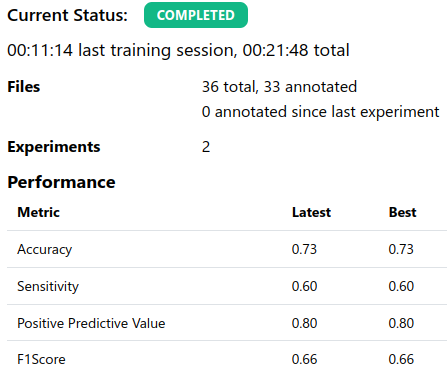

# Predict

In [ ]:
predictions_batches: list[Tensor] = trainer.predict(model, test_dataloader)
# list of tensors. each tensor has shape (batch_size, #classes, H, W)

In [ ]:
# visualize predictions:

k = 0
for prediction_batch in predictions_batches:
    # prediction_batch is a tensor of shape (batch_size, #classes, H, W)
    for prediction in prediction_batch:
        item = Dtest[k]
        image = item['image']

        segs = item['segmentations']
        # draw the segmentations
        # image_with_mask = draw_masks(image,
        #                              masks=segs[1:] == 1,
        #                              mask_color=(0, 255, 0))
        prediction_mask = prediction[1:] == 1
        image_with_prediction = draw_masks(image,
                                           masks=prediction_mask)

        show(image_with_prediction)
        k += 1